In [1]:
#  conda create -n pymiescatt numpy scipy matplotlib shapely jupyter
#  conda activate pymiescatt
#  pip install PyMieScatt

In [2]:
import PyMieScatt as ps
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ps.MieQ(1.33+0.1j, 870, 50, asDict=True)

{'Qext': 0.04119422717013906,
 'Qsca': 0.0001286889121979507,
 'Qabs': 0.04106553825794111,
 'g': 0.005955730784099353,
 'Qpr': 0.041193460733623115,
 'Qback': 0.00019026121910254717,
 'Qratio': 1.4784585233721244}

In [4]:
ps.MieQ(1.33+0.1j, 870, 50)

(0.04119422717013906,
 0.0001286889121979507,
 0.04106553825794111,
 0.005955730784099353,
 0.041193460733623115,
 0.00019026121910254717,
 1.4784585233721244)

In [22]:
ps.RayleighMieQ(1.33+0.01j, 870, 0)

(0, 0, 0, 1.5, 0, 0, 0)

In [21]:
ps.RayleighMieQ(1.33+0.01j, 870, 50)

(0.0041753430994240295,
 0.00011805645915412197,
 0.004057286640269908,
 0,
 0.0041753430994240295,
 0.00017708468873118297,
 1.5)

In [25]:
import numpy as np

def RayleighMieQ(m, wavelength, diameter, nMedium=1.0, asDict=False, asCrossSection=False):
    #  http://pymiescatt.readthedocs.io/en/latest/forward.html#RayleighMieQ
    nMedium = nMedium.real
    m /= nMedium
    wavelength /= nMedium
    x = np.pi*diameter/wavelength
    print(x, m)
    if x==0:
        return 0, 0, 0, 1.5, 0, 0, 0
    elif x>0:
        LL = (m**2-1)/(m**2+2) # Lorentz-Lorenz term
        LLabsSq = np.abs(LL)**2
        print(LLabsSq)
        qsca = 8*LLabsSq*(x**4)/3 # B&H eq 5.8
        qabs=4*x*LL.imag # B&H eq. 5.11
        qext=qsca+qabs
        qback = 1.5*qsca # B&H eq. 5.9
        qratio = 1.5
        g = 0
        qpr = qext
        if asCrossSection:
            css = np.pi*(diameter/2)**2
            cext = css*qext
            csca = css*qsca
            cabs = css*qabs
            cpr = css*qpr
            cback = css*qback
            cratio = css*qratio
            if asDict:
                return dict(Cext=cext,Csca=csca,Cabs=cabs,g=g,Cpr=cpr,Cback=cback,Cratio=cratio)
            else:
                return cext, csca, cabs, g, cpr, cback, cratio
        else:
            if asDict:
                return dict(Qext=qext,Qsca=qsca,Qabs=qabs,g=g,Qpr=qpr,Qback=qback,Qratio=qratio)
            else:
                return qext, qsca, qabs, g, qpr, qback, qratio

In [26]:
RayleighMieQ(1.33+0.01j, 870, 50)

0.18055130193044788 (1.33+0.01j)
0.041659928807373924


(0.0041753430994240295,
 0.00011805645915412197,
 0.004057286640269908,
 0,
 0.0041753430994240295,
 0.00017708468873118297,
 1.5)

In [87]:
import numpy as np
from scipy.special import jv, yv
from scipy.integrate import trapz
def MieQ(m, wavelength, diameter, nMedium=1.0, asDict=False, asCrossSection=False):
#  http://pymiescatt.readthedocs.io/en/latest/forward.html#MieQ
    nMedium = nMedium.real
    m /= nMedium
    wavelength /= nMedium
    x = np.pi*diameter/wavelength
#     if x==0:
#         return 0, 0, 0, 1.5, 0, 0, 0
#     elif x<=0.05:
#         return RayleighMieQ(m, wavelength, diameter, nMedium, asDict)
#     elif x>0.05:
    nmax = np.round(2+x+4*(x**(1/3)))
    n = np.arange(1,nmax+1)
    n1 = 2*n+1
    n2 = n*(n+2)/(n+1)
    n3 = n1/(n*(n+1))
    x2 = x**2

#         print((m,x))
    an,bn = Mie_ab(m,x)

    qext = (2/x2)*np.sum(n1*(an.real+bn.real))
    qsca = (2/x2)*np.sum(n1*(an.real**2+an.imag**2+bn.real**2+bn.imag**2))
    qabs = qext-qsca
    print(qabs)
    g1 = [an.real[1:int(nmax)],
                an.imag[1:int(nmax)],
                bn.real[1:int(nmax)],
                bn.imag[1:int(nmax)]]
    g1 = [np.append(x, 0.0) for x in g1]
    g = (4/(qsca*x2))*np.sum((n2*(an.real*g1[0]+an.imag*g1[1]+bn.real*g1[2]+bn.imag*g1[3]))+(n3*(an.real*bn.real+an.imag*bn.imag)))

    qpr = qext-qsca*g
    qback = (1/x2)*(np.abs(np.sum(n1*((-1)**n)*(an-bn)))**2)
    qratio = qback/qsca
    if asCrossSection:
        css = np.pi*(diameter/2)**2
        cext = css*qext
        csca = css*qsca
        cabs = css*qabs
        cpr = css*qpr
        cback = css*qback
        cratio = css*qratio
        if asDict:
            return dict(Cext=cext,Csca=csca,Cabs=cabs,g=g,Cpr=cpr,Cback=cback,Cratio=cratio)
        else:
            return cext, csca, cabs, g, cpr, cback, cratio
    else:
        if asDict:
            return dict(Qext=qext,Qsca=qsca,Qabs=qabs,g=g,Qpr=qpr,Qback=qback,Qratio=qratio)
        else:
            return qext, qsca, qabs, g, qpr, qback, qratio

def Mie_ab(m,x):
#  http://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_ab
    mx = m*x
    nmax = np.round(2+x+4*(x**(1/3)))
    nmx = np.round(max(nmax,np.abs(mx))+16)
    n = np.arange(1,nmax+1) #
    nu = n + 0.5 #
    
    sx = np.sqrt(0.5*np.pi*x)

    px = sx*jv(nu,x) #

    p1x = np.append(np.sin(x), px[0:int(nmax)-1]) #

    chx = -sx*yv(nu,x) #
    ch1x = np.append(np.cos(x), chx[0:int(nmax)-1]) #
    
    gsx = px-(0+1j)*chx #
    gs1x = p1x-(0+1j)*ch1x #

    # B&H Equation 4.89
    Dn = np.zeros(int(nmx),dtype=complex)
    for i in range(int(nmx)-1,1,-1):
        Dn[i-1] = (i/mx)-(1/(Dn[i]+i/mx))

        
    D = Dn[1:int(nmax)+1] # Dn(mx), drop terms beyond nMax
    da = D/m+n/x
    db = m*D+n/x

    an = (da*px-p1x)/(da*gsx-gs1x)
    bn = (db*px-p1x)/(db*gsx-gs1x)
#     print(an, bn)

    return an, bn

In [88]:
MieQ(1.33+0.01j, 870, 0.000001)

8.114573280539818e-11


(8.114573280539818e-11,
 1.888903346465918e-35,
 8.114573280539818e-11,
 -9.254709628125125e-15,
 8.114573280539818e-11,
 2.83335501969893e-35,
 1.500000000000028)

In [89]:
Mie_ab((1.33+0.01j), 0.18055130193044788)


(array([2.27711770e-05-7.99538247e-04j, 3.97066701e-08-1.49919804e-06j,
        3.40574920e-11-1.30842204e-09j, 1.68268918e-14-6.52532841e-13j]),
 array([1.13446052e-07-3.27061389e-06j, 1.05488115e-10-3.04543257e-09j,
        5.45689508e-14-1.57613599e-12j, 1.79686608e-17-5.19111813e-16j]))

In [134]:
def ScatteringFunction(m, wavelength, diameter, nMedium=1.0, minAngle=0, maxAngle=180, angularResolution=0.5, space='theta', angleMeasure='radians', normalization=None):
#  http://pymiescatt.readthedocs.io/en/latest/forward.html#ScatteringFunction
    nMedium = nMedium.real
    m /= nMedium
    wavelength /= nMedium
    x = np.pi*diameter/wavelength

    _steps = int(1+(maxAngle-minAngle)/angularResolution) # default 361
    
    if angleMeasure in ['radians','RADIANS','rad','RAD']:
        adjust = np.pi/180
    elif angleMeasure in ['gradians','GRADIANS','grad','GRAD']:
        adjust = 1/200
    else:
        adjust = 1

    if space in ['q','qspace','QSPACE','qSpace']:
        # _steps *= 10
        _steps += 1
        if minAngle==0:
            minAngle = 1e-5
        #measure = np.logspace(np.log10(minAngle),np.log10(maxAngle),_steps)*np.pi/180
        measure = np.linspace(minAngle, maxAngle, _steps)*np.pi/180
        _q = True
    else:
        measure = np.linspace(minAngle,maxAngle,_steps)*adjust
        _q = False
    if x == 0:
        return measure,0,0,0
    _measure = np.linspace(minAngle,maxAngle,_steps)*np.pi/180

    SL = np.zeros(_steps)
    SR = np.zeros(_steps)
    SU = np.zeros(_steps)
    for j in range(_steps):
        u = np.cos(_measure[j])
        S1, S2 = MieS1S2(m,x,u)
        SL[j] = (np.sum(np.conjugate(S1)*S1)).real
        SR[j] = (np.sum(np.conjugate(S2)*S2)).real
        SU[j] = (SR[j]+SL[j])/2
    if normalization in ['m','M','max','MAX']:
        SL /= np.max(SL)
        SR /= np.max(SR)
        SU /= np.max(SU)
    elif normalization in ['t','T','total','TOTAL']:
        SL /= trapz(SL,measure)
        SR /= trapz(SR,measure)
        SU /= trapz(SU,measure)
    if _q:
        measure = (4*np.pi/wavelength)*np.sin(measure/2)*(diameter/2)
    return measure,SL,SR,SU


def MieS1S2(m,x,mu):
#  http://pymiescatt.readthedocs.io/en/latest/forward.html#MieS1S2
    nmax = np.round(2+x+4*np.power(x,1/3))
    an, bn = Mie_ab(m,x)
    pin, taun = MiePiTau(mu,nmax)

    n = np.arange(1,int(nmax)+1)
    n2 = (2*n+1)/(n*(n+1))

    S1 = np.sum(n2[0:len(an)]*(an*pin[0:len(an)]+bn*taun[0:len(bn)]))
    S2 = np.sum(n2[0:len(an)]*(an*taun[0:len(an)]+bn*pin[0:len(bn)]))

    return S1, S2

def MiePiTau(mu,nmax):
#  http://pymiescatt.readthedocs.io/en/latest/forward.html#MiePiTau
    p = np.zeros(int(nmax))
    t = np.zeros(int(nmax))

    p[0] = 1
    p[1] = 3*mu
    t[0] = mu
    t[1] = 3.0*np.cos(2*np.arccos(mu))
    for n in range(2,int(nmax)):
        p[n] = ((2*n+1)*(mu*p[n-1])-(n+1)*p[n-2])/n
        t[n] = (n+1)*mu*p[n]-(n+2)*p[n-1]

    return p, t


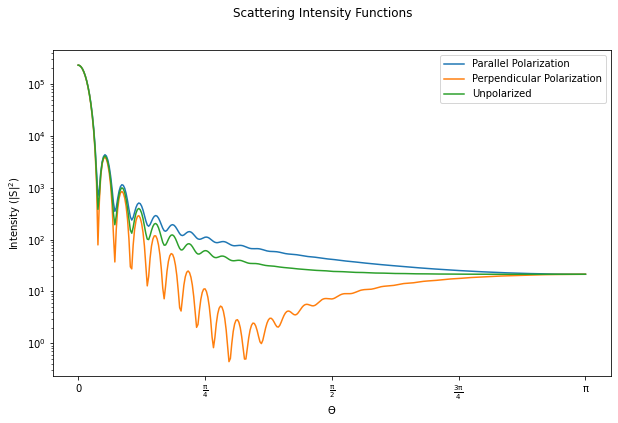

In [135]:
m=1.7+0.5j
w=532
d=5000

theta,SL,SR,SU = ScatteringFunction(m,w,d);

fig1 = plt.figure(figsize=(10,6))
fig1.suptitle("Scattering Intensity Functions")

ax1 = fig1.add_subplot(1,1,1)
ax1.semilogy(theta, SL, label="Parallel Polarization")
ax1.semilogy(theta, SR, label="Perpendicular Polarization")
ax1.semilogy(theta, SU, label="Unpolarized")

ax1.set_xlabel("ϴ")
x_label = ["0", r"$\mathregular{\frac{\pi}{4}}$", r"$\mathregular{\frac{\pi}{2}}$",r"$\mathregular{\frac{3\pi}{4}}$",r"$\mathregular{\pi}$"]
x_tick = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ax1.set_xticks(x_tick)
ax1.set_xticklabels(x_label)
ax1.set_ylabel(r"Intensity ($\mathregular{|S|^2}$)")

plt.legend()
plt.show()
